In this notebook we test loading the pretrained PSF model and predicting the monochromatic PSFs at the 10k training + 1k testing positions. The monochromatic PSF are added to the main dataset under the key "mono_psfs_approx".

Actual loading of the models and mono PSF generation is done through python scripts in the 'psf_model' folder.

In [1]:
from wf_psf.psf_models import psf_models
from wf_psf.utils.read_config import read_stream
from wf_psf.utils.configs_handler import *

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap

import tensorflow as tf

/Users/ec270266/anaconda3/envs/wavediff/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Pre-defined colormap
top = mpl.colormaps['Oranges_r'].resampled(128)
bottom = mpl.colormaps['Blues'].resampled(128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)), bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [3]:
pretrained_models_path = '/Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/psf_model/outputs/wf-outputs/pretrained_models/'

config_files_folder = pretrained_models_path + 'config/'
model_config_file = pretrained_models_path + 'config/configs_50.yaml'
model_training_config_file = pretrained_models_path + 'config/training_config_50.yaml'
model_data_config_file = pretrained_models_path + 'config/data_config_50.yaml'

checkpoint_dir = pretrained_models_path + 'psf_model/psf_50/'

repo_dir = '../../../../wf-psf/'
output_dir = '../../psf_model/outputs/'


In [4]:
configs_path = os.path.dirname(model_config_file)
configs = read_stream(model_config_file)
configs_file = os.path.basename(model_config_file)

file_handler = FileIOHandler(repo_dir, output_dir, configs_path)
file_handler.setup_outputs()
file_handler.copy_conffile_to_output_dir(configs_file)

for i, conf in enumerate(configs):
    print(i, conf)
    for k, v in conf.items():
        print(k)
        print(v)



0 {'training_conf': 'training_config_50.yaml'}
training_conf
training_config_50.yaml


In [5]:
config_class = get_run_config(k, os.path.join(config_files_folder, v), file_handler)

2025-01-27 14:29:26,493 - wf_psf.utils.read_config - INFO - Loading.../Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/psf_model/outputs/wf-outputs/pretrained_models/config/training_config_50.yaml
2025-01-27 14:29:26,499 - wf_psf.utils.read_config - INFO - Loading.../Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/psf_model/outputs/wf-outputs/pretrained_models/config/data_config_50.yaml


In [6]:
train_conf_handler = TrainingConfigHandler(model_training_config_file, file_handler)
data_conf_handler = DataConfigHandler(model_data_config_file, train_conf_handler.training_conf.training.model_params)

2025-01-27 14:29:27,019 - wf_psf.utils.read_config - INFO - Loading.../Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/psf_model/outputs/wf-outputs/pretrained_models/config/training_config_50.yaml
2025-01-27 14:29:27,023 - wf_psf.utils.read_config - INFO - Loading.../Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/psf_model/outputs/wf-outputs/pretrained_models/config/data_config_50.yaml
2025-01-27 14:29:27,468 - wf_psf.utils.read_config - INFO - Loading.../Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/psf_model/outputs/wf-outputs/pretrained_models/config/data_config_50.yaml


In [7]:
psf_model = psf_models.get_psf_model(
        train_conf_handler.training_conf.training.model_params,
        train_conf_handler.training_conf.training.training_hparams,
        data_conf_handler,
    )

# Load pretrained model weights

In [8]:
chkp = tf.train.latest_checkpoint(checkpoint_dir)
psf_model.load_weights(chkp)

# Load the test datasets

In [9]:
inputs_0 = data_conf_handler.test_data.dataset["positions"]
inputs_1 = data_conf_handler.test_data.sed_data

gt_psfs = data_conf_handler.test_data.dataset['stars']

zks = data_conf_handler.test_data.dataset['zernike_coef']
zks_tf = zks.reshape(zks.shape[0], -1, 1, 1)
zks_tf.shape
gt_wfe = psf_model.tf_zernike_OPD(zks_tf)

In [10]:
inputs_0[0:0+1]

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[436.59375, 374.09204]], dtype=float32)>

In [11]:
tf.convert_to_tensor(np.array([[100, 100]]), dtype=tf.float32)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[100., 100.]], dtype=float32)>

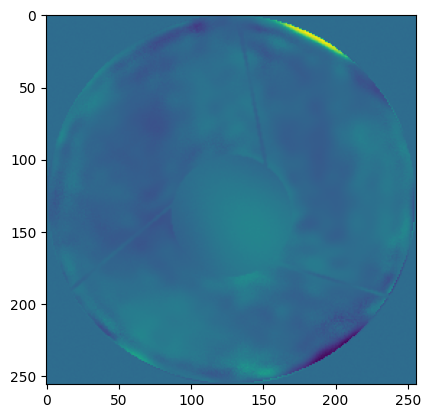

In [12]:
plt.imshow(psf_model.predict_opd( tf.convert_to_tensor(np.array([[100, 100]]), dtype=tf.float32) )[0])

In [13]:
print('    Phase_N,      lambdas,        SED')
print(inputs_1[0])

    Phase_N,      lambdas,        SED
tf.Tensor(
[[7.46000000e+02 5.70918381e-01 9.98004153e-02]
 [8.04000000e+02 6.15306139e-01 1.05820075e-01]
 [8.60000000e+02 6.58163249e-01 1.20882660e-01]
 [9.16000000e+02 7.02551007e-01 1.21629998e-01]
 [9.74000000e+02 7.45408177e-01 1.38427421e-01]
 [1.03200000e+03 7.89795935e-01 1.39279485e-01]
 [1.09000000e+03 8.34183693e-01 1.38363108e-01]
 [1.14600000e+03 8.77040803e-01 1.35796830e-01]], shape=(8, 3), dtype=float32)


1/1 [==============================] - 3s 3s/step


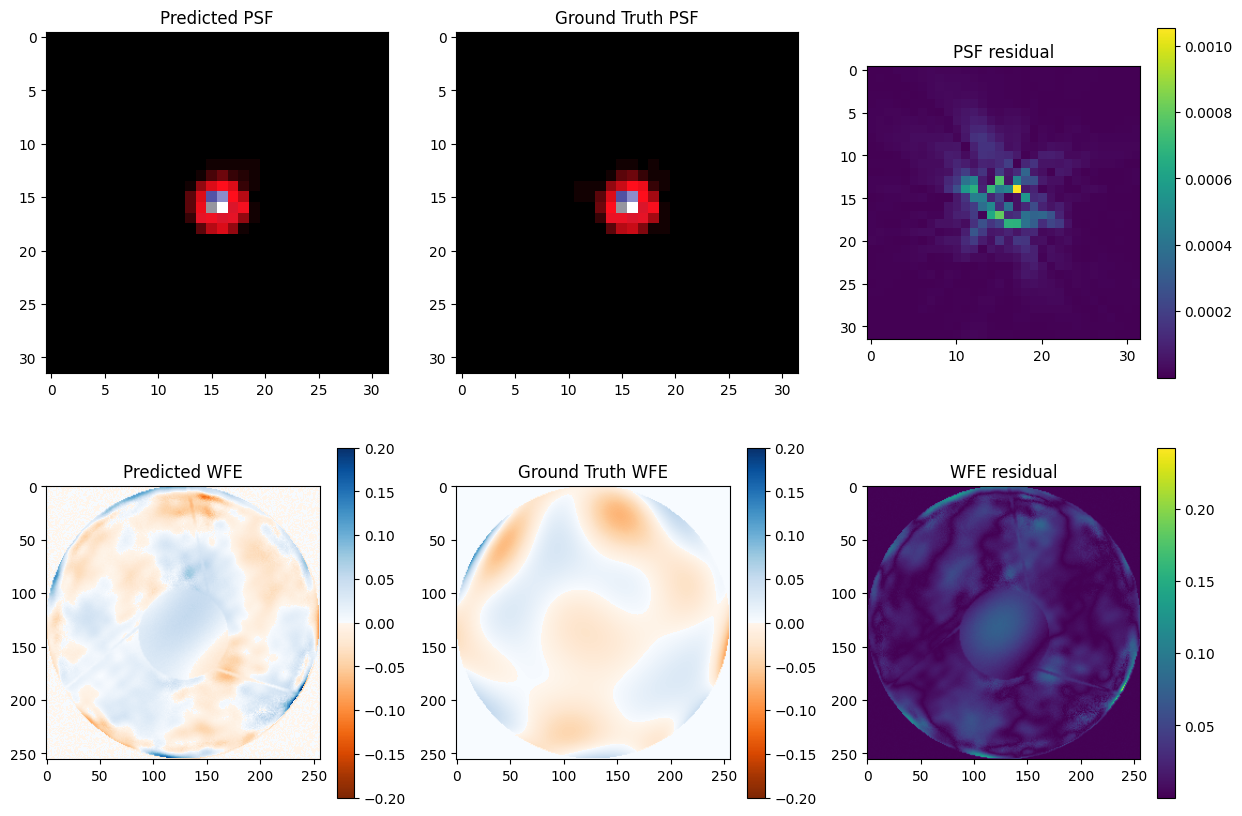

In [14]:
for i in range(1):
    idx=np.random.randint(0, inputs_0.shape[0])

    opd_test =psf_model.predict_opd(inputs_0[idx:idx+1])
    psf = psf_model.predict([inputs_0[idx:idx+1], inputs_1[idx:idx+1]])

    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    cax = ax[1][0].imshow(opd_test[0], cmap=newcmp, vmin=-.2, vmax=.2)
    fig.colorbar(cax, ax=ax[1][0], orientation='vertical')
    cax = ax[1][1].imshow(gt_wfe[idx], cmap=newcmp, vmin=-.2, vmax=.2)
    fig.colorbar(cax, ax=ax[1][1], orientation='vertical')
    cax = ax[1][2].imshow(np.abs(opd_test[0] - gt_wfe[idx]), cmap='viridis')
    fig.colorbar(cax, ax=ax[1][2], orientation='vertical')
    
    ax[0][0].imshow(psf[0], cmap='gist_stern')
    ax[0][1].imshow(gt_psfs[idx], cmap='gist_stern')
    cax = ax[0][2].imshow(np.abs(psf[0] - gt_psfs[idx]), cmap='viridis')
    fig.colorbar(cax, ax=ax[0][2], orientation='vertical')

    ax[1][0].set_title('Predicted WFE')
    ax[1][1].set_title('Ground Truth WFE')
    ax[1][2].set_title('WFE residual')
    ax[0][0].set_title('Predicted PSF')
    ax[0][1].set_title('Ground Truth PSF')
    ax[0][2].set_title('PSF residual')
    plt.show()

In [15]:
idx

791

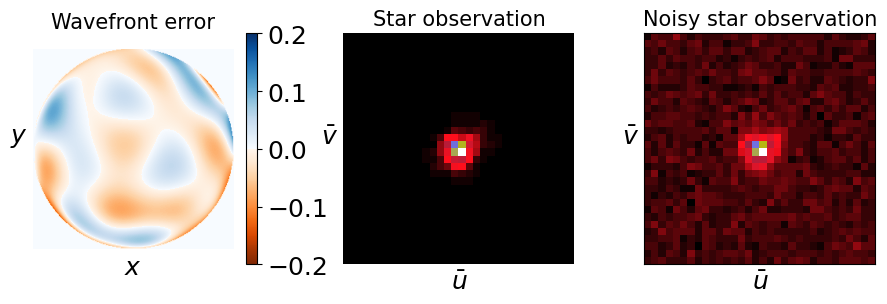

In [16]:
# Paper figure WFE and PSF

#set font size
plt.rcParams.update({'font.size': 18})

idx=77

# opd_test =psf_model.predict_opd(inputs_0[idx:idx+1])
# psf = psf_model.predict([inputs_0[idx:idx+1], inputs_1[idx:idx+1]])

fig, ax = plt.subplots(1, 3, figsize=(11, 3))

cax = ax[0].imshow(gt_wfe[idx], cmap=newcmp, vmin=-.2, vmax=.2)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$', rotation=0, labelpad=10)
ax[0].set_xticks([])
ax[0].set_yticks([])
# remove frame
for spine in ax[0].spines.values():
    spine.set_visible(False)

fig.colorbar(cax, ax=ax[0], orientation='vertical')

ax[1].imshow(gt_psfs[idx], cmap='gist_stern')
ax[1].set_xlabel(r'$\bar{u}$')
ax[1].set_ylabel(r'$\bar{v}$', rotation=0, labelpad=10)
ax[1].set_xticks([])
ax[1].set_yticks([])
for spine in ax[1].spines.values():
    spine.set_visible(False)
ax[2].imshow(data_conf_handler.test_data.dataset['noisy_stars'][idx], cmap='gist_stern')
ax[2].set_xlabel(r'$\bar{u}$')
ax[2].set_ylabel(r'$\bar{v}$', rotation=0, labelpad=10)
ax[2].set_xticks([])
ax[2].set_yticks([])

ax[0].set_title('Wavefront error', pad=15, fontsize=15)
ax[1].set_title('Star observation', fontsize=15)
ax[2].set_title('Noisy star observation', fontsize=15)
plt.savefig('../figures/wfe_psf_example.pdf', bbox_inches='tight')
# plt.show()

In [17]:
data_conf_handler.test_data.dataset['packed_SEDs'][0][1]

array([0.57091837, 0.61530612, 0.65816327, 0.70255102, 0.74540816,
       0.78979592, 0.83418367, 0.87704082])

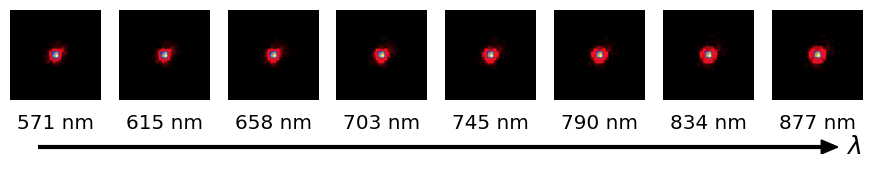

In [18]:
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
# plot the mono psfs
plt.rcParams.update({'font.size': 12})
plt.subplots(1,8, figsize=(11, 2))

for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(data_conf_handler.test_data.dataset['mono_psfs'][idx][i], cmap='gist_stern')
    plt.title('{:.0f} nm'.format(np.array(data_conf_handler.test_data.dataset['packed_SEDs'][0][1][i])*1e3), y=-0.4)
    plt.axis('off')

ax2 = plt.axes([0.15, 0, .75, .7], facecolor=(1,1,1,0))

x,y = np.array([[0, .95], [0.05, 0.05]])
line = Line2D(x, y, lw=3., color='k', )
ax2.add_line(line)
ax2.set_axis_off()

pts = np.array([[.95,0], [.95,.1], [.97,.05]])
p = Polygon(pts, color='k')
ax2.add_patch(p)

# Add text 
plt.text(0.98, 0, r'$\lambda$', fontsize=18)

plt.savefig('../figures/mono_psfs_example.pdf', bbox_inches='tight')


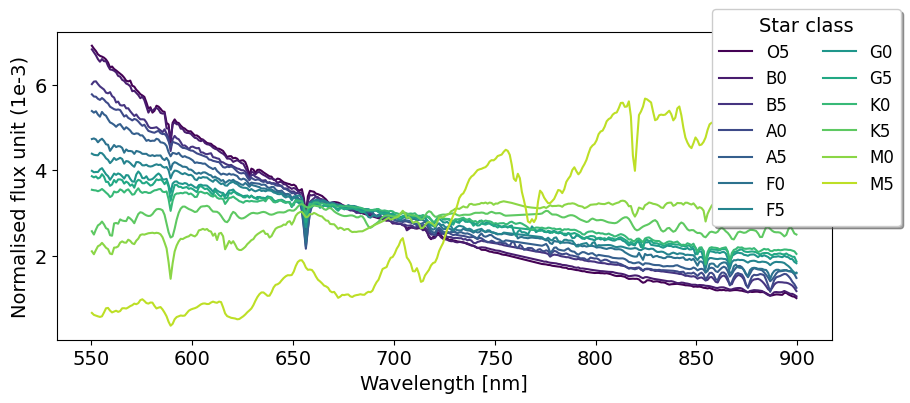

In [20]:
# Plot the SEDs
plt.rcParams.update({'font.size': 14})
color_palette = plt.cm.viridis(np.linspace(0, 0.9, 13))
star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

sed_idx = [np.where(np.array(data_conf_handler.test_data.dataset['SED_ids']) == i)[0][0] for i in range(13)]

plt.figure(figsize=(10, 4))

for i in range(13):
    SED_data = data_conf_handler.test_data.dataset['SEDs'][sed_idx[i]]
    plt.plot(SED_data[:,0], SED_data[:,1]*1e3, label=star_class_labels[i], color=color_palette[i])

plt.legend(loc='upper right',  ncol=2, fontsize=12, title='Star class', title_fontsize='14', shadow=True, fancybox=True, bbox_to_anchor=(1.1, 1.1))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Normalised flux unit (1e-3)')
# plt.grid(True)
plt.savefig('../figures/SEDs.pdf', bbox_inches='tight')


In [21]:
data_conf_handler.test_data.dataset['SEDs'][0]

array([[5.50500000e+02, 2.10526572e-03],
       [5.51500000e+02, 2.03695876e-03],
       [5.52500000e+02, 2.13510722e-03],
       [5.53500000e+02, 2.22392312e-03],
       [5.54500000e+02, 2.24889742e-03],
       [5.55500000e+02, 2.30239543e-03],
       [5.56500000e+02, 2.24822557e-03],
       [5.57500000e+02, 2.18823689e-03],
       [5.58500000e+02, 2.15563020e-03],
       [5.59500000e+02, 2.05105373e-03],
       [5.60500000e+02, 2.03717155e-03],
       [5.61500000e+02, 2.19123109e-03],
       [5.62500000e+02, 2.19515422e-03],
       [5.63500000e+02, 2.21985741e-03],
       [5.64500000e+02, 2.30715677e-03],
       [5.65500000e+02, 2.33721321e-03],
       [5.66500000e+02, 2.31000406e-03],
       [5.67500000e+02, 2.30694181e-03],
       [5.68500000e+02, 2.37671023e-03],
       [5.69500000e+02, 2.34899016e-03],
       [5.70500000e+02, 2.29187363e-03],
       [5.71500000e+02, 2.27323660e-03],
       [5.72500000e+02, 2.35398805e-03],
       [5.73500000e+02, 2.40165753e-03],
       [5.745000

In [21]:
# data_conf_handler.test_data.dataset['SED_ids']

# Load the 10k stars dataset

In [25]:
dataset_10k_path = '/Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/output/psf_dataset/train_12000_stars_id_002_8bins.npy'
dataset_10k = np.load(dataset_10k_path, allow_pickle=True)[()]
dataset_10k.keys()

dict_keys(['stars', 'noisy_stars', 'mono_psfs', 'positions', 'SEDs', 'packed_SEDs', 'zernike_coef', 'C_poly', 'parameters', 'SED_ids', 'SNR'])

In [26]:
packed_SEDs = np.array([dataset_10k['packed_SEDs'][i].T for i in dataset_10k['SED_ids']])
packed_SEDs.shape

(12000, 8, 3)

In [27]:
idx_offset = 2000
n_stars = 10000
inputs_0 = dataset_10k['positions'][idx_offset:idx_offset+n_stars]
inputs_1 = packed_SEDs[idx_offset:idx_offset+n_stars]

gt_psfs = dataset_10k['stars'][idx_offset:idx_offset+n_stars]

1/1 [==============================] - 2s 2s/step


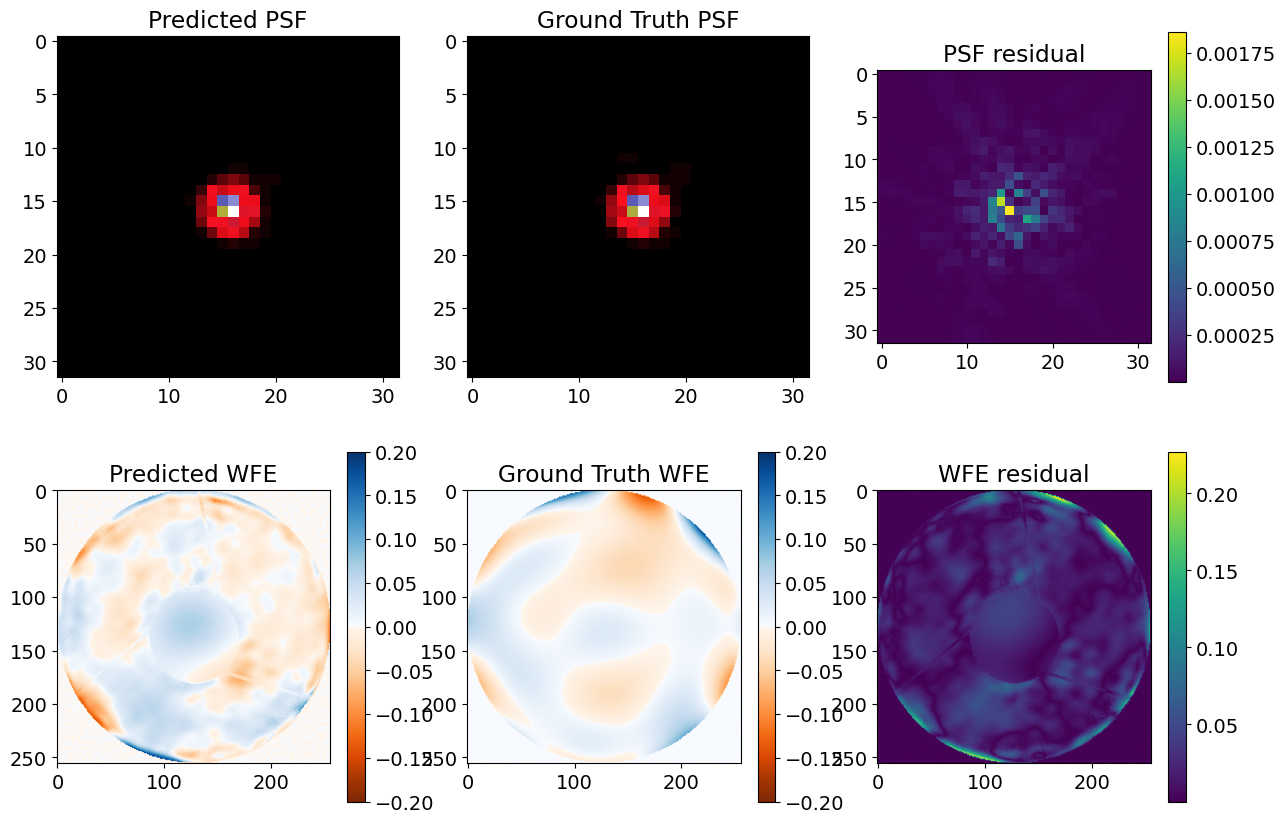

In [28]:
zks = dataset_10k['zernike_coef'][idx_offset:idx_offset+1]
zks_tf = tf.convert_to_tensor(zks.reshape(zks.shape[0], -1, 1, 1))
# time consuming (kernel might crash)#
gt_wfe = psf_model.tf_zernike_OPD(zks_tf)

for i in range(1):

    # idx=np.random.randint(0, inputs_0.shape[0])
    idx = 0
    opd_test =psf_model.predict_opd(inputs_0[idx:idx+1])
    psf = psf_model.predict([inputs_0[idx:idx+1], inputs_1[idx:idx+1]])

    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    cax = ax[1][0].imshow(opd_test[0], cmap=newcmp, vmin=-.2, vmax=.2)
    fig.colorbar(cax, ax=ax[1][0], orientation='vertical')
    cax = ax[1][1].imshow(gt_wfe[idx], cmap=newcmp, vmin=-.2, vmax=.2)
    fig.colorbar(cax, ax=ax[1][1], orientation='vertical')
    cax = ax[1][2].imshow(np.abs(opd_test[0] - gt_wfe[idx]), cmap='viridis')
    fig.colorbar(cax, ax=ax[1][2], orientation='vertical')
    
    ax[0][0].imshow(psf[0], cmap='gist_stern')
    ax[0][1].imshow(gt_psfs[idx], cmap='gist_stern')
    cax = ax[0][2].imshow(np.abs(psf[0] - gt_psfs[idx]), cmap='viridis')
    fig.colorbar(cax, ax=ax[0][2], orientation='vertical')

    ax[1][0].set_title('Predicted WFE')
    ax[1][1].set_title('Ground Truth WFE')
    ax[1][2].set_title('WFE residual')
    ax[0][0].set_title('Predicted PSF')
    ax[0][1].set_title('Ground Truth PSF')
    ax[0][2].set_title('PSF residual')
    plt.show()

# Predict the monochromatic PSFs

In [29]:
n_batch = 2
mono_psfs = [[psf_model.predict_mono_psfs(inputs_0[idx:idx+1], float(inputs_1[idx:idx+1,wv,1]), int(inputs_1[idx:idx+1,wv,0]))[0] for wv in range(dataset_10k['parameters']['n_bins'])] for idx in range(n_batch)]

2024-09-17 15:10:17,954 - tensorflow - WARNING - Setting parallel_iterations > 1 has no effect when executing eagerly. Consider calling map_fn with tf.function to execute fn in parallel.


In [30]:
inputs_0.shape

(10000, 2)

In [31]:
for in_1 in inputs_1[0,:,:2]:
    print(in_1[1])

0.5709183673469388
0.6153061224489795
0.6581632653061225
0.7025510204081632
0.745408163265306
0.7897959183673469
0.8341836734693877
0.8770408163265306


In [32]:
n_batch = 3
batch_size = 2
mono_psfs = np.empty((0, 8, 32, 32))
inputs_0 = np.array(inputs_0)
inputs_1 = np.array(inputs_1)
for i in range(n_batch):
	mono_psfs_batch = np.array([psf_model.predict_mono_psfs(tf.convert_to_tensor(inputs_0[2000:2000+batch_size]), in_1[1], int(in_1[0])) for in_1 in inputs_1[0,:,:2]])
	mono_psfs = np.append(mono_psfs, np.swapaxes(mono_psfs_batch, 0, 1), axis=0)
mono_psfs.shape

(6, 8, 32, 32)

In [33]:
n_batch = 3
batch_size = 2
mono_psfs = np.empty((0, 8, 32, 32))
inputs_0 = np.array(inputs_0)
inputs_1 = np.array(inputs_1)
for i in range(n_batch):
	mono_psfs_batch = np.array([psf_model.predict_mono_psfs(tf.convert_to_tensor(inputs_0[i*batch_size:(i+1)*batch_size]), in_1[1], int(in_1[0])) for in_1 in inputs_1[0,:,:2]])
	mono_psfs = np.append(mono_psfs, np.swapaxes(mono_psfs_batch, 0, 1), axis=0)
mono_psfs.shape

(6, 8, 32, 32)

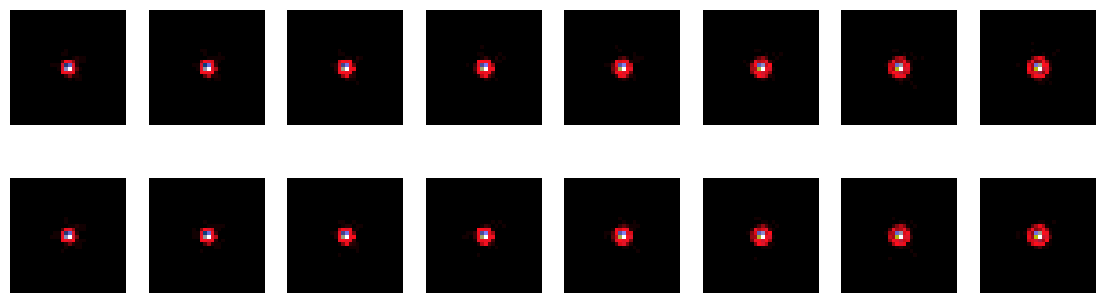

In [34]:
# plot monoc psfs and the poly psf
im, ax = plt.subplots(2, dataset_10k['parameters']['n_bins'], figsize=(14, 4))

for i in range(dataset_10k['parameters']['n_bins']):
    ax[0][i].imshow(dataset_10k['mono_psfs'][2000,i], cmap='gist_stern')
    ax[0][i].axis('off')
    ax[1][i].imshow(mono_psfs[0,i], cmap='gist_stern')
    ax[1][i].axis('off')

In [22]:
dataset_10k['mono_psfs_approx'] = mono_psfs
dataset_10k.keys()

dict_keys(['stars', 'noisy_stars', 'mono_psfs', 'positions', 'SEDs', 'packed_SEDs', 'zernike_coef', 'C_poly', 'parameters', 'SED_ids', 'SNR', 'mono_psfs_approx'])